Программа для исследования влияния ошибок моделирования механической системы на точность определения параметров этой системы с помощью метода наименьших квадратов

Работу выполнил Крымов Роман

In [1]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

Рассматривается равноускоренное движение, описываемое уравнением
$$ \vec{r}(t) = \vec{r}_0 + \vec{v}_0(t-t_0) + \frac{1}{2}\vec{a}_0(t-t_0)^2. $$
Требуется с помощью измерений, полученных в заданные моменты времени, восстановить начальные параметры системы. Обязательно измеряется положение, дополнительно может измеряться скорость. Обязательно определяются начальное положение и скорость, дополнительно может определяться ускорение, в противном случае оно полагается равным нулю. Таким образом, рассматриваются 4 случая, отвечающие разным наборам измерений и наличию/отсутствию ошибки моделирования (равноускоренное движение заменяется равномерным).

In [2]:
def predict_motion(time_steps, pos_init, vel_init, acc_init):
    pos = pos_init + vel_init[np.newaxis,:] * time_steps[:,np.newaxis] + \
          0.5 * acc_init[np.newaxis,:] * (time_steps**2)[:,np.newaxis]
    vel = vel_init + acc_init[np.newaxis,:] * time_steps[:,np.newaxis]
    return pos, vel

Оценку начальных параметров системы $\vec{r}_0^{estim}, \vec{v}_0^{estim}, \vec{a}_0^{estim}$ будем получать с помощью метода наименьших квадратов, то есть минимизировать функцию суммы квадратов невязок
$$ L \big( \vec{r}_0^{estim}, \vec{v}_0^{estim}, \vec{a}_0^{estim} \big) \to \min_{\vec{r}_0^{estim}, \vec{v}_0^{estim}, \vec{a}_0^{estim}}. $$
В случае, когда измеряется только положение:
$$ L \big( \vec{r}_0^{estim}, \vec{v}_0^{estim}, \vec{a}_0^{estim} \big| \{\vec{r}^{meas}_k\}_{k=1}^{m} \big) = \sum_{k=1}^{m} \frac{1}{\sigma_r^2} \bigg| \vec{r}^{estim} \big( t_k, \vec{r}_0^{estim}, \vec{v}_0^{estim}, \vec{a}_0^{estim} \big) - \vec{r}^{meas}_k \bigg|^2.$$
В случае, когда измеряется и положение, и скорость:
$$ L \big( \vec{r}_0^{estim}, \vec{v}_0^{estim}, \vec{a}_0^{estim} \big| \{\vec{r}^{meas}_k\}_{k=1}^{m}, \{\vec{v}^{meas}_k\}_{k=1}^{m} \big) = \sum_{k=1}^{m} \frac{1}{\sigma_r^2} \bigg| \vec{r}^{estim} \big( t_k, \vec{r}_0^{estim}, \vec{v}_0^{estim}, \vec{a}_0^{estim} \big) - \vec{r}^{meas}_k \bigg|^2 + \sum_{k=1}^{m} \frac{1}{\sigma_v^2} \bigg| \vec{v}^{estim} \big( t_k, \vec{r}_0^{estim}, \vec{v}_0^{estim}, \vec{a}_0^{estim} \big) - \vec{v}^{meas}_k \bigg|^2. $$

In [3]:
def squared_residuals_sum(vector_dim, model_params, time_steps, \
                          pos_error_std, pos_meas, vel_error_std, vel_meas):
    pos_init = model_params[0:vector_dim]
    vel_init = model_params[vector_dim:2*vector_dim]
    acc_init = np.zeros(vector_dim)
    if model_params.size == 3*vector_dim:
        acc_init = model_params[2*vector_dim:3*vector_dim]
    pos_estim, vel_estim = predict_motion(time_steps, pos_init, vel_init, acc_init)
    result = np.sum((pos_meas - pos_estim)**2)/pos_error_std
    if vel_meas.size != 0:
        result += np.sum((vel_meas - vel_estim)**2)/vel_error_std
    return result

Вычислим ошибку оценок начальных параметров системы, полученных после обработки измерений

In [4]:
def get_state_errors(pos_exact_init, vel_exact_init, acc_exact_init, time_steps, \
                     pos_error_std, vel_error_std, count_ensemble, count_cases):
    count_time_steps = time_steps.size
    pos_exact, vel_exact = predict_motion(time_steps, pos_exact_init, vel_exact_init, acc_exact_init)
    pos_init_error = np.zeros((count_time_steps, count_ensemble, count_cases))
    vel_init_error = np.zeros((count_time_steps, count_ensemble, count_cases))
    acc_init_error = np.zeros((count_time_steps, count_ensemble, count_cases))
    for j in range(count_ensemble):
        pos_error = np.random.randn(count_time_steps, vector_dim) * pos_error_std
        pos_meas = pos_exact + pos_error
        vel_error = np.random.randn(count_time_steps, vector_dim) * vel_error_std
        vel_meas = vel_exact + vel_error
        for i in range(count_time_steps):
            x0 = np.random.randn(3*vector_dim)
            for k in range(count_cases):
                cost_function = lambda x: squared_residuals_sum(vector_dim, model_params=x, time_steps[0:i+1], \
                                                                pos_error_std, pos_meas[0:i+1,:], \
                                                                vel_error_std, vel_meas[0:(i+1)*(k%2),:])
                res = minimize(cost_function, x0[:(2 + k//2)*vector_dim], \
                               method='nelder-mead', options={'xtol': 1e-8, 'disp': False})
                pos_estim_init = res.x[0:vector_dim]
                vel_estim_init = res.x[vector_dim:2*vector_dim]
                acc_estim_init = np.zeros(vector_dim)
                if k//2 != 0:
                    acc_estim_init = res.x[2*vector_dim:3*vector_dim]
                pos_init_error[i,j,k] = np.linalg.norm(pos_estim_init - pos_exact_init)
                vel_init_error[i,j,k] = np.linalg.norm(vel_estim_init - vel_exact_init)
                #для определения скорости без её измерения требуется 2 измерения положения
                if (i <= ((k+1)%2)*(k//2 + 1)):
                    vel_init_error[i,j,k] = np.nan
                acc_init_error[i,j,k] = np.linalg.norm(acc_estim_init - acc_exact_init)
                #для определения ускорения требуется 3 измерения положения или
                #                                    2 измерения положения и скорости
                if (i <= k//2 + 1 - k%2):
                    acc_init_error[i,j,k] = np.nan
    return pos_init_error, vel_init_error, acc_init_error

Для простоты будем рассматривать случай прямолинейного движения

In [5]:
vector_dim = 1
pos_exact_init = np.ones(vector_dim)
vel_exact_init = np.zeros(vector_dim)
acc_exact_init = np.zeros(vector_dim)
acc_exact_init = np.ones(vector_dim) * 0.01
count_ensemble = 1000
count_cases = 4
final_time = 10
time_steps = np.linspace(0.0, final_time, num=20)
pos_error_std = 0.1
vel_error_std = 0.1
pos_init_error, vel_init_error, acc_init_error = get_state_errors(pos_exact_init, vel_exact_init, acc_exact_init, \
                                                                  time_steps, pos_error_std, vel_error_std, \
                                                                  count_ensemble, count_cases)

Посмотрим, как ошибка оценок начальных параметров системы, полученных после обработки измерений, зависит от числа измерений

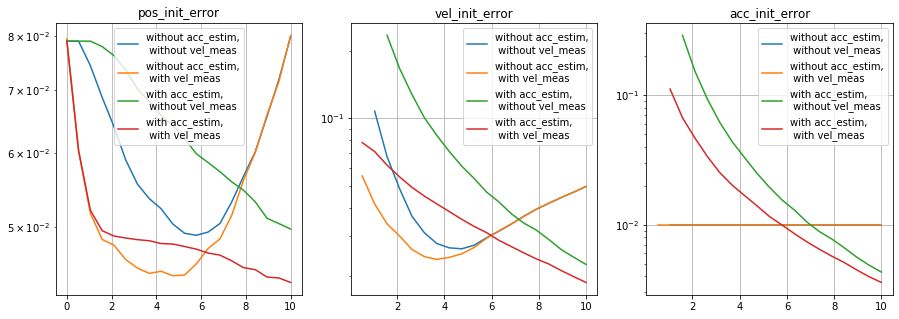

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5));

labels_list = ['without acc_estim,\n without vel_meas', 'without acc_estim,\n with vel_meas', \
              'with acc_estim,\n without vel_meas', 'with acc_estim,\n with vel_meas']

for k in range(count_cases):
    axes[0].semilogy(time_steps, pos_init_error[:,:,k].mean(axis=1), label=labels_list[k])
    axes[1].semilogy(time_steps, vel_init_error[:,:,k].mean(axis=1), label=labels_list[k])
    axes[2].semilogy(time_steps, acc_init_error[:,:,k].mean(axis=1), label=labels_list[k])

titles_list = ['pos', 'vel', 'acc']
for l in range(3):
    axes[l].grid()
    axes[l].set_title(titles_list[l]+'_init_error')
    axes[l].legend()

Как можно заметить, когда дополнительно измеряется скорость, оценки получаются более точными, хотя с увеличением числа измерений это различие уменьшается. При небольшом числе измерений более простая модель даёт более точные оценки, при увеличении числа измерений, вернее при увеличении мерного интервала, ситуация меняется на противоположную, поскольку существенное влияние начинают оказывать ошибки моделирования (ускорение не оценивается и считается равным нулю).